### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

#### 1.1

In [72]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import scipy
import swiftascmaps

In [73]:
data = np.load('/Users/toralcm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw8_data_1.npy')

In [74]:
data

array([(19.46392, 18.89363, 18.85225, 18.8241 , 18.53599, 'QSO', 2.312959  , 1.925222e-04),
       (18.33262, 16.29118, 15.3018 , 14.81997, 14.45467, 'GALAXY', 0.05187586, 1.396275e-05),
       (18.85941, 17.01412, 15.97252, 15.51533, 15.11948, 'GALAXY', 0.09769295, 1.805014e-05),
       ...,
       (18.76492, 18.12947, 18.04838, 17.94089, 17.677  , 'QSO', 2.267401  , 1.777254e-04),
       (19.36827, 19.06754, 18.9035 , 18.84508, 18.82694, 'QSO', 1.407278  , 8.702147e-04),
       (19.37275, 18.82985, 18.69858, 18.53639, 18.43456, 'QSO', 0.6865192 , 1.417279e-04)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [75]:
#arrays of colors
u_g = data['u']-data['g']
g_r = data['g']-data['r']
r_i = data['r']-data['i']
i_z = data['i']-data['z']

#array of redshift and spectral class
redshift = data['redshift']
redshift_err = data['redshift_err']
spectral_class = data['specClass']

#how many galaxies
print("Number of galaxies:", np.sum(spectral_class=='GALAXY'))

#how many quasars
print("Number of quasars:",np.sum(spectral_class=='QSO'))

Number of galaxies: 42808
Number of quasars: 7192


#### 1.2

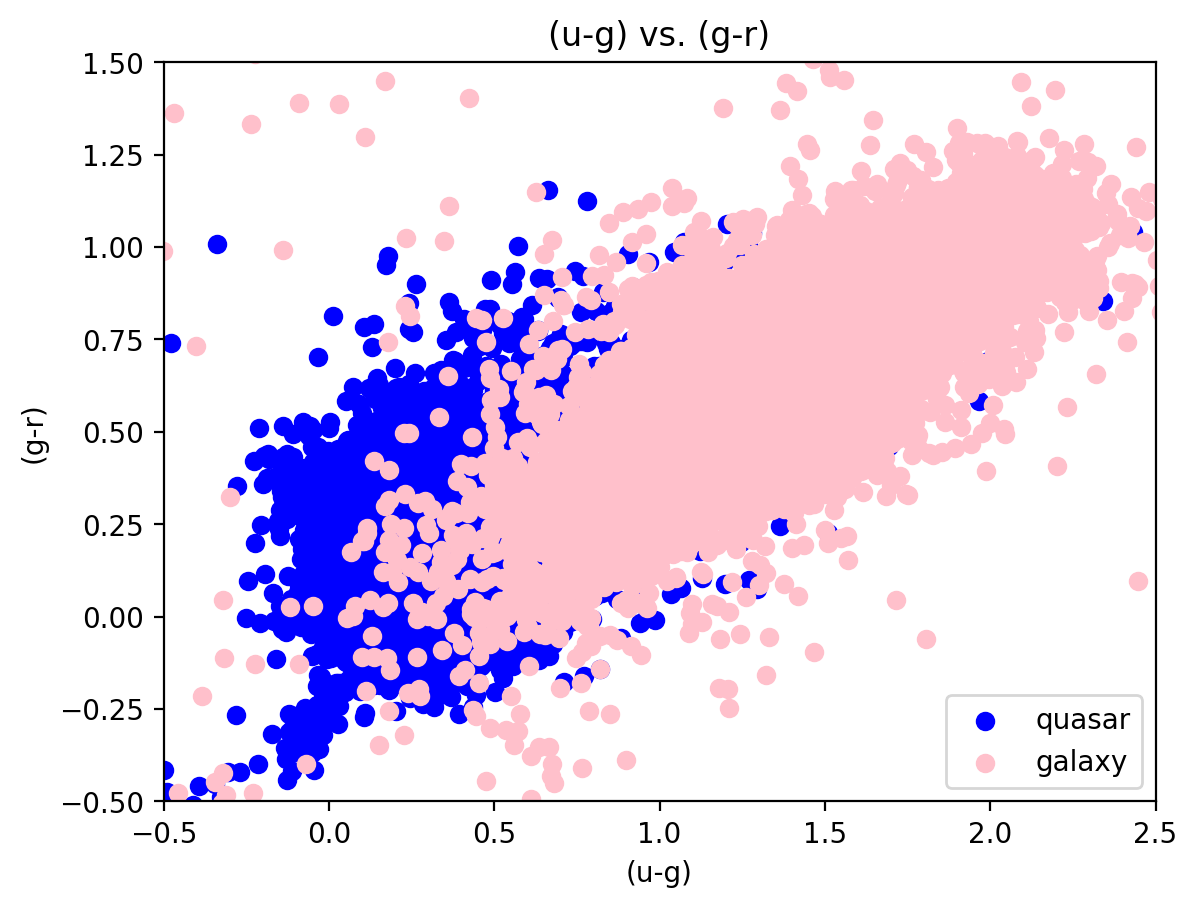

In [215]:
#scatter plot
quasars = np.where(spectral_class == 'QSO')[0]
galaxies = np.where(spectral_class == 'GALAXY')[0]

#quasar plot
plt.scatter(u_g[quasars], g_r[quasars], c='blue', label='quasar')

#galaxy plot
plt.scatter(u_g[galaxies], g_r[galaxies], c='pink', label='galaxy')

plt.xlabel('(u-g)')
plt.ylabel('(g-r)')
plt.title('(u-g) vs. (g-r)')
plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.legend()

plt.show()

#### 1.3

In [77]:
#create data matrix
X = np.column_stack((u_g, g_r, r_i, i_z, redshift))
X

array([[0.57029   , 0.04138   , 0.02815   , 0.28811   , 2.312959  ],
       [2.04144   , 0.98938   , 0.48183   , 0.3653    , 0.05187586],
       [1.84529   , 1.0416    , 0.45719   , 0.39585   , 0.09769295],
       ...,
       [0.63545   , 0.08109   , 0.10749   , 0.26389   , 2.267401  ],
       [0.30073   , 0.16404   , 0.05842   , 0.01814   , 1.407278  ],
       [0.5429    , 0.13127   , 0.16219   , 0.10183   , 0.6865192 ]])

In [78]:
#make new array with labels 0 and 1
spectral_labels = []
labels = {'GALAXY': 0,'QSO': 1,}

for i in spectral_class:
    spectral_labels.append(labels[i])

spectral_labels

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,


In [79]:
#train-test split 
from sklearn.model_selection import train_test_split
Xtest, Xtrain, spectral_labels_test, spectral_labels_train = train_test_split(X, spectral_labels, test_size=0.2)


#### 1.4

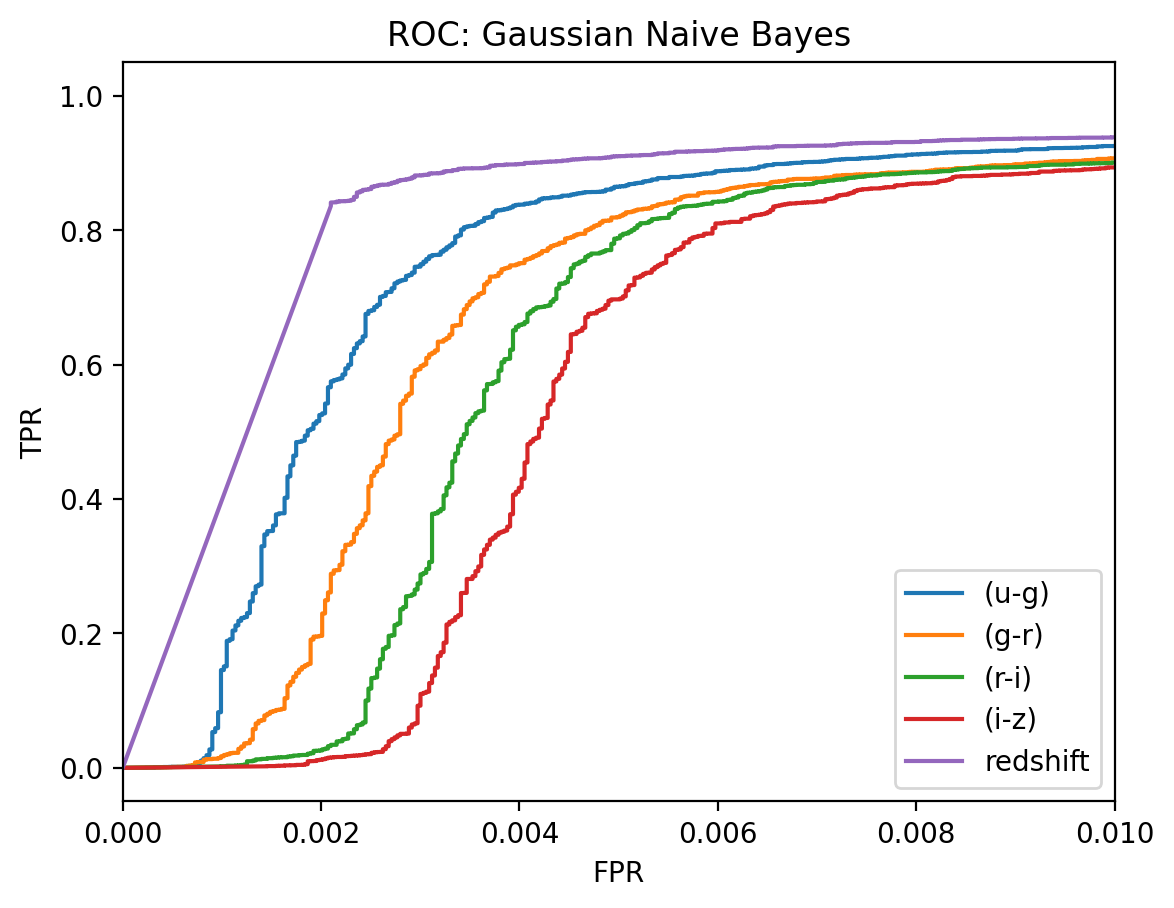

In [80]:
from sklearn.naive_bayes import GaussianNB
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

#from lecture 19 -- perform gaussian naive bayes
Xlabels = ['(u-g)','(g-r)', '(r-i)', '(i-z)','redshift']

for nf in range(0,X.shape[1]):
    clf = GaussianNB()
    clf.fit(Xtrain[:, :nf+1], spectral_labels_train)

    spectral_prob = clf.predict_proba(Xtest[:, :nf+1])[:,1]

    #plot roc curve
    fpr, tpr, thresh = roc_curve(spectral_labels_test, spectral_prob)
    precision, recall, thresh2 = precision_recall_curve(spectral_labels_test, spectral_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    plt.plot(fpr, tpr, label = Xlabels[nf]) 


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC: Gaussian Naive Bayes')
plt.xlim(0,0.01)
plt.legend()

plt.show()


#### 1.5

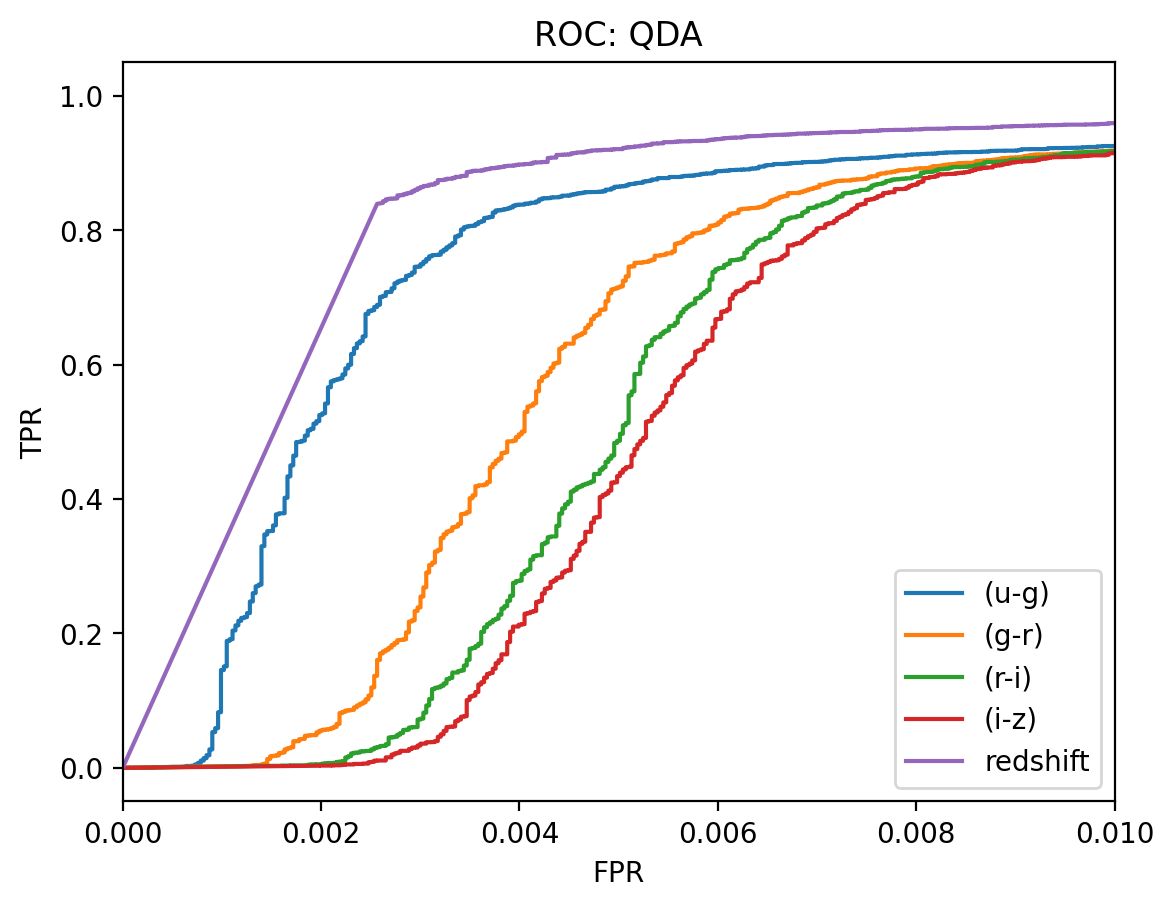

In [82]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

for nf in range(0,X.shape[1]):
    qda = QDA()
    qda.fit(Xtrain[:, :nf+1], spectral_labels_train)

    #spectral_predQDA = qda.predict(Xtest[:, :nf])[:,1]
    
    spectral_probQDA = qda.predict_proba(Xtest[:, :nf+1])[:,1]
    
    #plot roc curve
    fpr_q, tpr_q, thresh_q = roc_curve(spectral_labels_test, spectral_probQDA)
    precision_q, recall_q, thresh2_q = precision_recall_curve(spectral_labels_test, spectral_probQDA)

    # add (0, 0) as first point
    fpr_q = np.concatenate([[0], fpr_q])
    tpr_q = np.concatenate([[0], tpr_q])

    # Here we add (1,0) 
    precision_q = np.concatenate([[0], precision_q])
    recall_q = np.concatenate([[1], recall_q])
    thresh2_q = np.concatenate([[0], thresh2_q])

    plt.plot(fpr_q, tpr_q, label = Xlabels[nf]) 

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC: QDA')
plt.xlim(0,0.01)
plt.legend()

plt.show()

#### 1.6

In [83]:
#make new X matrix with only the 4 colors
X4 = np.column_stack((u_g, g_r, r_i, i_z))
X4

array([[0.57029, 0.04138, 0.02815, 0.28811],
       [2.04144, 0.98938, 0.48183, 0.3653 ],
       [1.84529, 1.0416 , 0.45719, 0.39585],
       ...,
       [0.63545, 0.08109, 0.10749, 0.26389],
       [0.30073, 0.16404, 0.05842, 0.01814],
       [0.5429 , 0.13127, 0.16219, 0.10183]])

In [86]:
#new train-test split
from sklearn.model_selection import train_test_split
X4test, X4train, spectral_labels4_test, spectral_labels4_train = train_test_split(X4, spectral_labels, test_size=0.2)


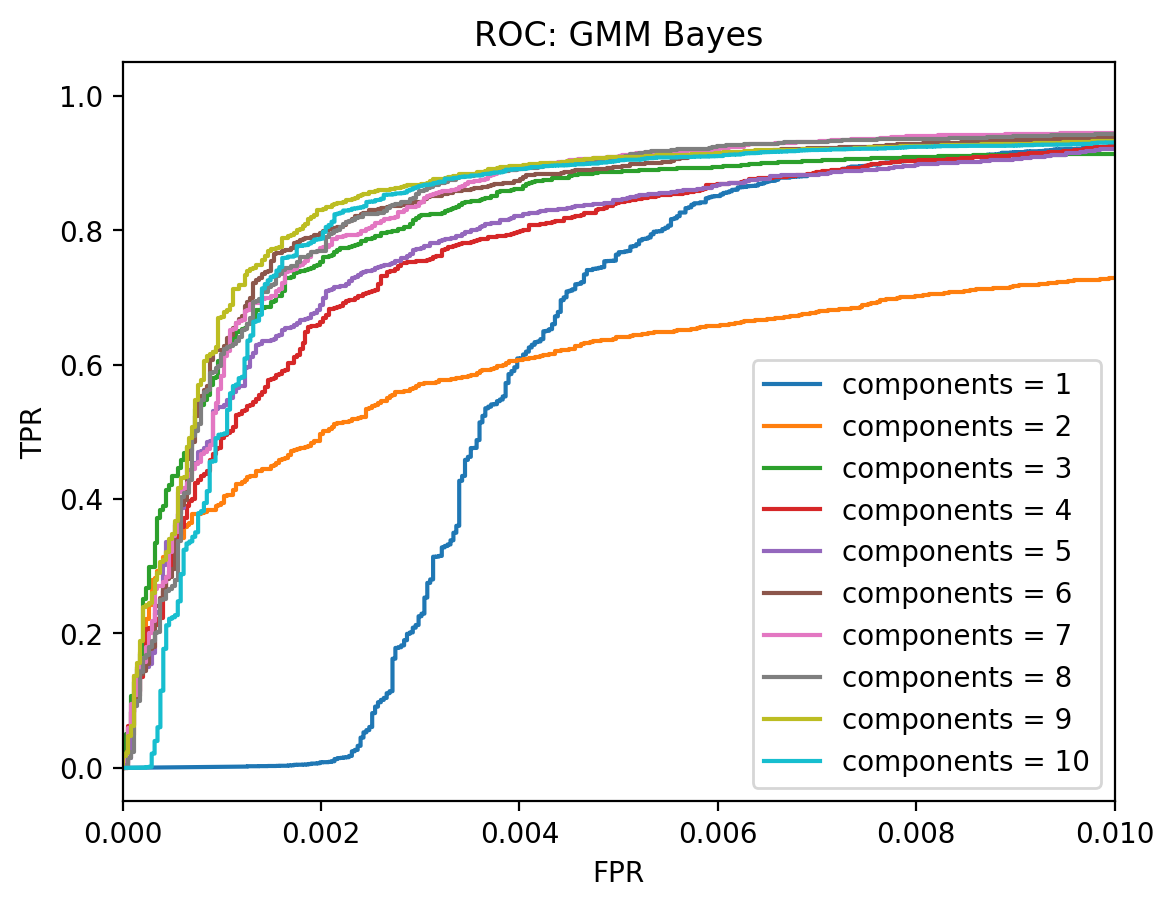

In [118]:
#classification with GMM Bayes
from astroML.classification import GMMBayes

gmm_labels = ['components = 1','components = 2','components = 3','components = 4','components = 5',
              'components = 6', 'components = 7','components = 8','components = 9','components = 10']

n_components = range(1, 11)

for n in n_components:
    gmm = GMMBayes(n)
    gmm.fit(X4train, spectral_labels4_train)
    spectral4_prob = gmm.predict_proba(X4test)[:,1]
            

    #plot roc curve
    fpr4, tpr4, thresh4 = roc_curve(spectral_labels4_test, spectral4_prob)
    precision4, recall4, thresh42 = precision_recall_curve(spectral_labels4_test, spectral4_prob)

    # add (0, 0) as first point
    fpr4 = np.concatenate([[0], fpr4])
    tpr4 = np.concatenate([[0], tpr4])

    # Here we add (1,0) 
    precision4 = np.concatenate([[0], precision4])
    recall4 = np.concatenate([[1], recall4])
    thresh42 = np.concatenate([[0], thresh42])
   #plot
    plt.plot(fpr4, tpr4, label = gmm_labels[n-1]) 

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, .01)
plt.title('ROC: GMM Bayes')
plt.legend()

plt.show()
              

In [182]:
#number of components that gives the best performance(using AUC (area under curve) score)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

from astroML.classification import GMMBayes
from sklearn.metrics import auc

auc_score = []
n_components = range(1, 10)

for n in n_components:
    gmm = GMMBayes(n)
    gmm.fit(X4train, spectral_labels4_train)
    spectral4_prob = gmm.predict_proba(X4test)[:,1]
            

    #plot roc curve
    fpr4, tpr4, thresh4 = roc_curve(spectral_labels4_test, spectral4_prob)
    precision4, recall4, thresh42 = precision_recall_curve(spectral_labels4_test, spectral4_prob)

    # add (0, 0) as first point
    fpr4 = np.concatenate([[0], fpr4])
    tpr4 = np.concatenate([[0], tpr4])

    # Here we add (1,0) 
    precision4 = np.concatenate([[0], precision4])
    recall4 = np.concatenate([[1], recall4])
    thresh42 = np.concatenate([[0], thresh42])
   
   #auc scores
    aucs = auc(fpr4, tpr4)
    auc_score.append(aucs)


print("index of best number of components:",np.argmax(auc_score))

index of best number of components: 5


In [121]:
print("best number of components:",n_components[7])

best number of components: 8


#### 1.7

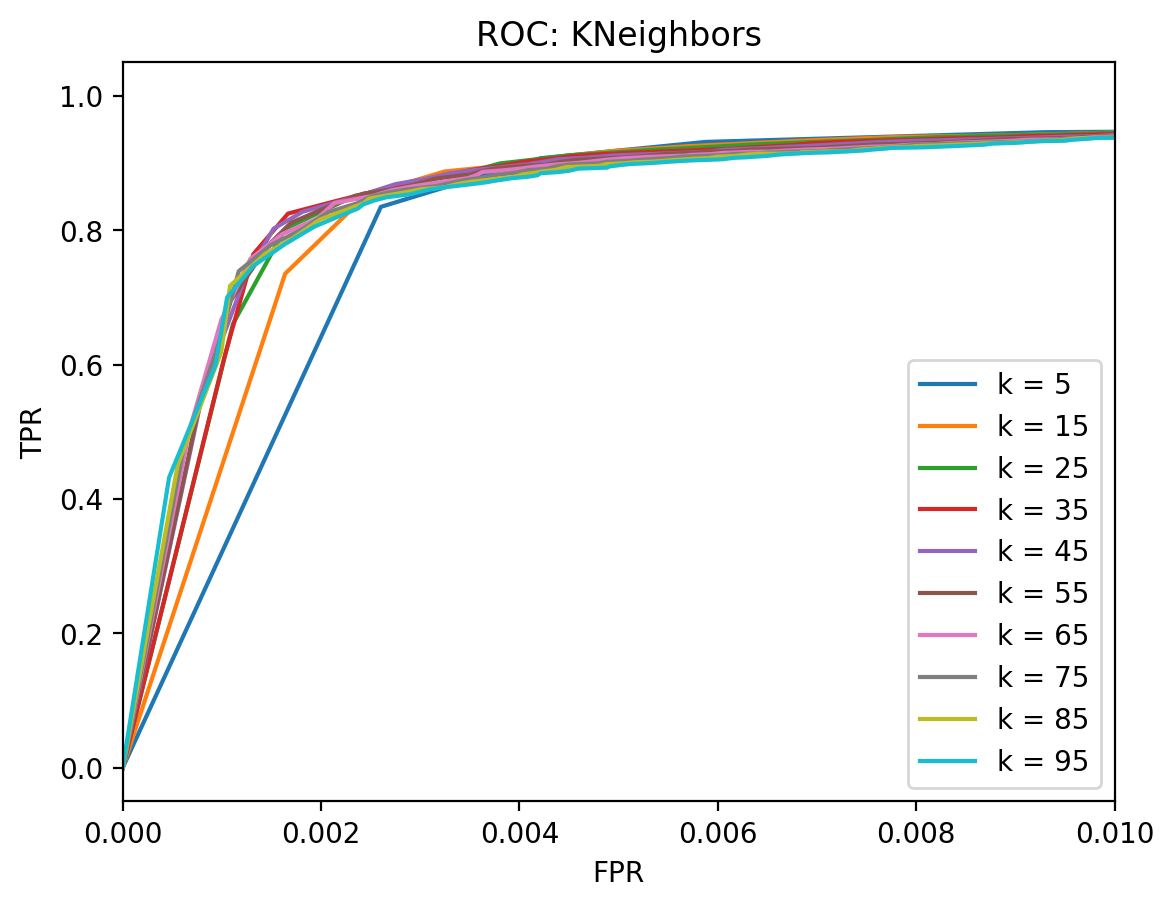

In [154]:
from sklearn.neighbors import KNeighborsClassifier


kneighbors = np.arange(5, 101, 10)


for k in kneighbors:
    knc = KNeighborsClassifier(k)
    knc.fit(X4train,spectral_labels4_train)



    spectral_k_prob = knc.predict_proba(X4test)[:,1]
    

    #plot roc curve
    fpr_k, tpr_k, thresh_k = roc_curve(spectral_labels4_test, spectral_k_prob)
    precision_k, recall_k, thresh2_k = precision_recall_curve(spectral_labels4_test, spectral_k_prob)

    # add (0, 0) as first point
    fpr_k = np.concatenate([[0], fpr_k])
    tpr_k = np.concatenate([[0], tpr_k])

    # Here we add (1,0) 
    precision_k = np.concatenate([[0], precision_k])
    recall_k = np.concatenate([[1], recall_k])
    thresh2_k = np.concatenate([[0], thresh2_k])
   #plot
    plt.plot(fpr_k, tpr_k, label = f'k = {int(k)}') 
    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, .01)
plt.title('ROC: KNeighbors')
plt.legend()

plt.show()

In [153]:
#best performance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

kneighbors = np.arange(5, 101, 10)
scores=[]

for k in kneighbors:
    knc = KNeighborsClassifier(k)
    knc.fit(X4train,spectral_labels4_train)

    spectral_k_prob = knc.predict_proba(X4test)[:,1]
    

    #plot roc curve
    fpr_k, tpr_k, thresh_k = roc_curve(spectral_labels4_test, spectral_k_prob)
    precision_k, recall_k, thresh2_k = precision_recall_curve(spectral_labels4_test, spectral_k_prob)

    # add (0, 0) as first point
    fpr_k = np.concatenate([[0], fpr_k])
    tpr_k = np.concatenate([[0], tpr_k])

    # Here we add (1,0) 
    precision_k = np.concatenate([[0], precision_k])
    recall_k = np.concatenate([[1], recall_k])
    thresh2_k = np.concatenate([[0], thresh2_k])

   #classification -- from lecture 19
    CVpredk = cross_val_predict(knc, X4train, spectral_labels4_train)
    scores.append(accuracy_score(spectral_labels4_train, CVpredk)) 

print("number of neighbors for best performance:",kneighbors[np.argmax(scores)])


number of neighbors for best performance: 5


#### 1.8

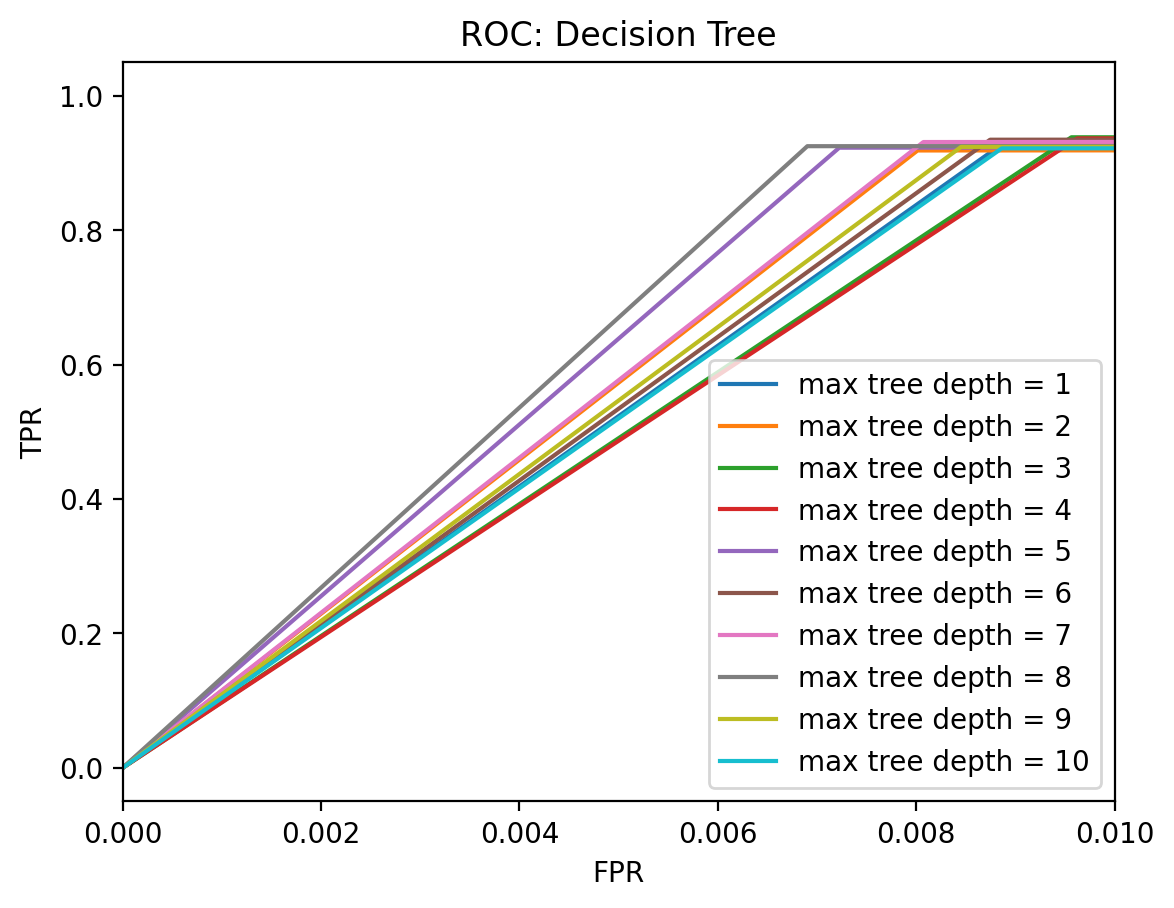

In [145]:
#from lecture 20
from sklearn.tree import DecisionTreeClassifier

tree_depth = range(1,11)

for td in tree_depth:
    d_tree = DecisionTreeClassifier(max_depth=td)
    d_tree.fit(X4train, spectral_labels4_train)
    spectral_dt_prob = d_tree.predict(X4test)

    #plot roc curve
    fpr_dt, tpr_dt, thresh_dt = roc_curve(spectral_labels4_test, spectral_dt_prob)
    precision_dt, recall_dt, thresh2_dt = precision_recall_curve(spectral_labels4_test, spectral_dt_prob)

    # add (0, 0) as first point
    fpr_dt = np.concatenate([[0], fpr_dt])
    tpr_dt = np.concatenate([[0], tpr_dt])

    # Here we add (1,0) 
    precision_dt = np.concatenate([[0], precision_dt])
    recall_dt = np.concatenate([[1], recall_dt])
    thresh2_dt = np.concatenate([[0], thresh2_dt])
   #plot
    plt.plot(fpr_dt, tpr_dt, label = f'max tree depth = {td}') 
    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, .01)
plt.title('ROC: Decision Tree')
plt.legend()

plt.show()
    




In [148]:
#best performance  -- using auc 

from sklearn.tree import DecisionTreeClassifier

tree_depth = range(1,11)
auc_score_td = []

for td in tree_depth:
    d_tree = DecisionTreeClassifier(max_depth=td)
    d_tree.fit(X4train, spectral_labels4_train)
    spectral_dt_prob = d_tree.predict(X4test)

    #plot roc curve
    fpr_dt, tpr_dt, thresh_dt = roc_curve(spectral_labels4_test, spectral_dt_prob)
    precision_dt, recall_dt, thresh2_dt = precision_recall_curve(spectral_labels4_test, spectral_dt_prob)

    # add (0, 0) as first point
    fpr_dt = np.concatenate([[0], fpr_dt])
    tpr_dt = np.concatenate([[0], tpr_dt])

    # Here we add (1,0) 
    precision_dt = np.concatenate([[0], precision_dt])
    recall_dt = np.concatenate([[1], recall_dt])
    thresh2_dt = np.concatenate([[0], thresh2_dt])
   
   #auc
    auc_td = auc(fpr_dt, tpr_dt)
    auc_score_td.append(auc_td)

print("best maximum tree depth:",np.argmax(auc_score_td))

best maximum tree depth: 2


#### 1.9

GaussianNB
QuadraticDiscriminantAnalysis
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


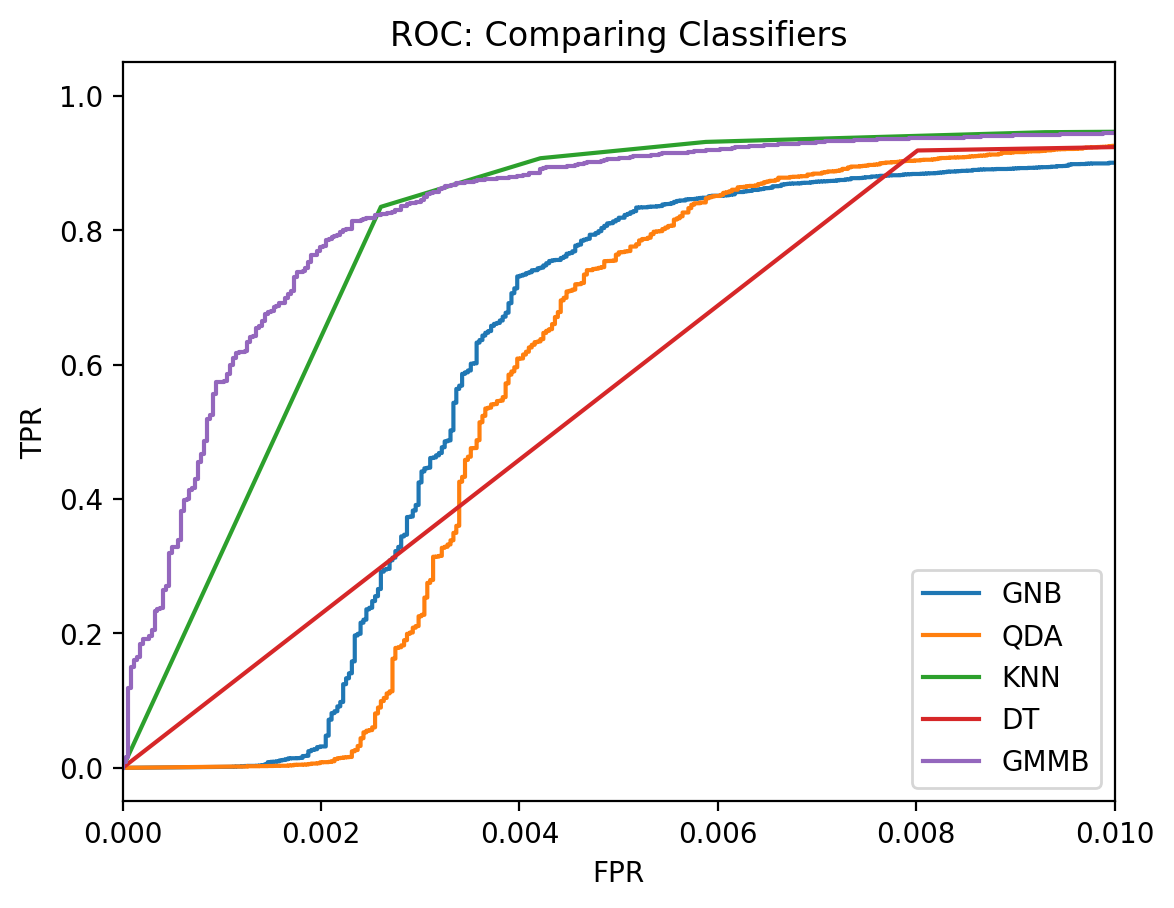

In [166]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve

#code from lecture 19

def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf9 = classifier(**kwargs)
        clf9.fit(X4train, spectral_labels4_train                                                                                                                             )
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        spec_probs = clf9.predict_proba(X4test)[:, 1]

        names.append(classifier.__name__)
        probs.append(spec_probs)

    return names, probs

names, probs = compute_models((GaussianNB, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=5)),
                              (DecisionTreeClassifier,
                               dict(max_depth=2)),
                              (GMMBayes, dict(n_components=8)))


labels9 = dict(GaussianNB='GNB',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB')

for name, prob in zip(names, probs):
    fpr9, tpr9, thresh9 = roc_curve(spectral_labels4_test, prob)
    precision9, recall9, thresh92 = precision_recall_curve(spectral_labels4_test, prob)

    # add (0, 0) as first point
    fpr9 = np.concatenate([[0], fpr9])
    tpr9 = np.concatenate([[0], tpr9])
    # Here we add (1,0) 
    precision9 = np.concatenate([[0], precision9])
    recall9 = np.concatenate([[1], recall9])
    thresh92 = np.concatenate([[0], thresh92])

    plt.plot(fpr9, tpr9, label=labels9[name])


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(0, .01)
plt.title('ROC: Comparing Classifiers')
plt.legend()

plt.show()



In [254]:
#which is the best performing classifier -- using auc since I used this for earlier problems

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


auc_classifiers = []

#code from lecture 19

def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf9 = classifier(**kwargs)
        clf9.fit(X4train, spectral_labels4_train                                                                                                                             )
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        spec_probs = clf9.predict_proba(X4test)[:, 1]

        names.append(classifier.__name__)
        probs.append(spec_probs)

    return names, probs

names, probs = compute_models((GaussianNB, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=5)),
                              (DecisionTreeClassifier,
                               dict(max_depth=2)),
                              (GMMBayes, dict(n_components=8)))


labels9 = dict(GaussianNB='GNB',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB')

for name, prob in zip(names, probs):
    fpr9, tpr9, thresh9 = roc_curve(spectral_labels4_test, prob)
    precision9, recall9, thresh92 = precision_recall_curve(spectral_labels4_test, prob)

    # add (0, 0) as first point
    fpr9 = np.concatenate([[0], fpr9])
    tpr9 = np.concatenate([[0], tpr9])
    # Here we add (1,0) 
    precision9 = np.concatenate([[0], precision9])
    recall9 = np.concatenate([[1], recall9])
    thresh92 = np.concatenate([[0], thresh92])

    auc_c = auc(fpr9, tpr9)
    auc_classifiers.append(auc_c)

index_auc = np.argmax(auc_classifiers)
name_auc = names[index_auc] #name of the classifier with max auc score
print("best performing classifier:", name_auc)


GaussianNB
QuadraticDiscriminantAnalysis
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes
best performing classifier: GMMBayes


#### 1.10

In [233]:
np.array(spectral_labels4_train)

array([0, 1, 0, ..., 1, 0, 0])

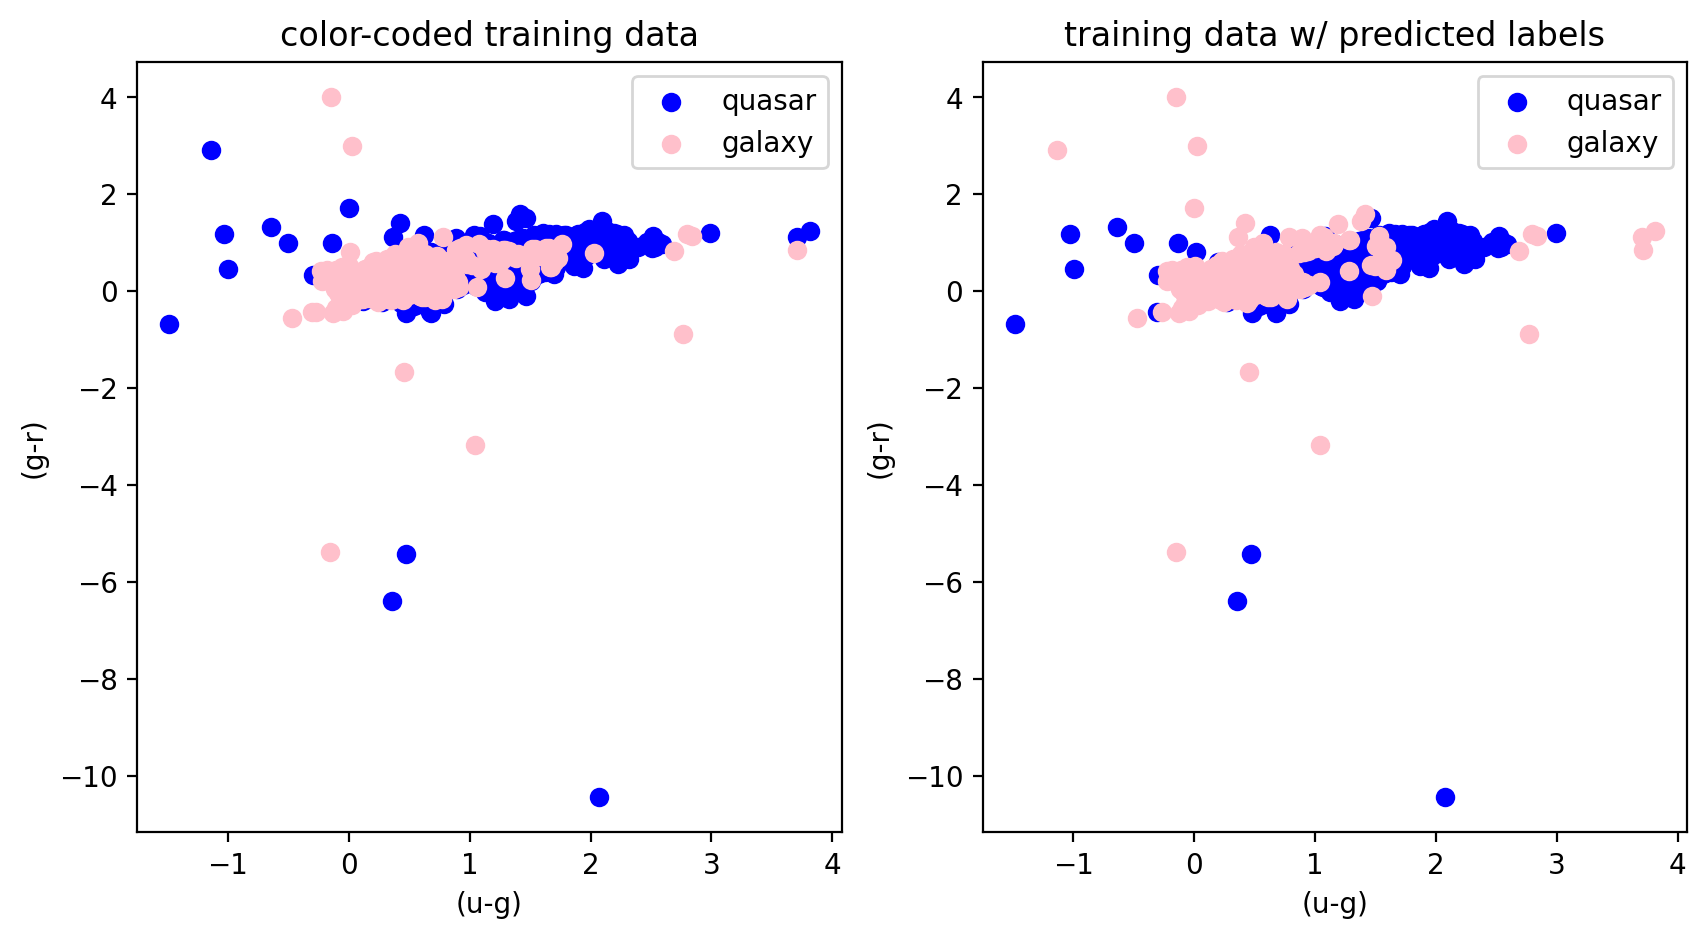

In [253]:
from astroML.classification import GMMBayes
#first panel 

fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 

q = np.where(np.array(spectral_labels4_train) == 0)[0]
g = np.where(np.array(spectral_labels4_train)  == 1)[0]

#quasar plot
u_g_train = X4train[:, 0]
g_r_train = X4train[:,1]

ax[0].scatter(u_g_train[q], g_r_train[q],c='blue',label='quasar')
ax[0].scatter(u_g_train[g], g_r_train[g], c='pink',label='galaxy')

ax[0].set_xlabel('(u-g)')
ax[0].set_ylabel('(g-r)')
ax[0].set_title('color-coded training data')


#second panel 
gmmb = GMMBayes(n_components=8)
gmmb.fit(X4train, spectral_labels4_train)
predict_colors = gmmb.predict(X4train)

#stil assigning 0=quasar, 1=galaxy
q2 = np.where(predict_colors== 0)[0]
g2 = np.where(predict_colors  == 1)[0]


ax[1].scatter(u_g_train[q2], g_r_train[q2], c='blue',label='quasar')
ax[1].scatter(u_g_train[g2], g_r_train[g2], c='pink',label='galaxy')

ax[1].set_xlabel('(u-g)')
ax[1].set_ylabel('(g-r)')
ax[1].set_title('training data w/ predicted labels')

ax[0].legend()
ax[1].legend()
plt.show()

